<a id = "1" ></a>
# Load Required Libraries

In [150]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

<a id = "2" ></a>
# Import the Dataset

T

In [151]:
#import dataset
df = pd.read_csv("Email spam.csv")
#true = pd.read_csv("data/True.csv")

In [152]:
#data exploration
df.head(10)

,Id,spam,text
0,1.0,1.0,Subject: naturally irresistible your corporate...
1,2.0,1.0,Subject: the stock trading gunslinger fanny i...
2,3.0,1.0,Subject: unbelievable new homes made easy im ...
3,4.0,1.0,Subject: 4 color printing special request add...
4,5.0,1.0,"Subject: do not have money , get software cds ..."
5,6.0,1.0,"Subject: great nnews hello , welcome to medzo..."
6,7.0,1.0,Subject: here ' s a hot play in motion homela...
7,8.0,1.0,Subject: save your money buy getting this thin...
8,9.0,1.0,Subject: undeliverable : home based business f...
9,10.0,1.0,Subject: save your money buy getting this thin...


In [153]:
print(df.columns)


Index(['Id', 'spam', 'text'], dtype='object')


In [154]:
df.rename(columns={"spam": "Category"}, inplace=True)


In [155]:
#true.head()

In [156]:
from sklearn.preprocessing import LabelEncoder
le_3 = LabelEncoder()
label_3=le_3.fit_transform(df["Category"])
df["Category"]=label_3
df.head(10)


,Id,Category,text
0,1.0,1,Subject: naturally irresistible your corporate...
1,2.0,1,Subject: the stock trading gunslinger fanny i...
2,3.0,1,Subject: unbelievable new homes made easy im ...
3,4.0,1,Subject: 4 color printing special request add...
4,5.0,1,"Subject: do not have money , get software cds ..."
5,6.0,1,"Subject: great nnews hello , welcome to medzo..."
6,7.0,1,Subject: here ' s a hot play in motion homela...
7,8.0,1,Subject: save your money buy getting this thin...
8,9.0,1,Subject: undeliverable : home based business f...
9,10.0,1,Subject: save your money buy getting this thin...


The columns in the datasets are:
* **title** - The title of the article
* **text** - The text of the article
* **subject** - The subject of the article
* **date** - The date at which the article was posted

The dataset contains no target variable. We need to create manually and add it to the datasets. We will create a binary variable called label. The label variable will have '0' for real news and '1' for fake news. 

In [157]:
df.rename(columns={"text": "Message"}, inplace=True)


In [158]:
X_data=df[["Message"]]
Y_data=df["Category"]


In [159]:
#adding label columns to both fake news and true news dataset
#fake["label"] = 1
#true["label"] = 0

We will combine the seperate datasets into one for our further analysis

In [160]:
#combining both the datasets into one
#df = pd.concat([fake, true], ignore_index = True)
#df

In [161]:
print(df.isnull().sum())


Id          1
Category    0
Message     1
dtype: int64


In [162]:
df = df.dropna()


In [163]:
df['Message'] = df['Message'].fillna('')


In [164]:
df = df[df['Message'].str.strip() != '']


In [165]:
print(df['Category'].value_counts())


Category
0    1540
1    1368
2       1
Name: count, dtype: int64


In [166]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduce splits

scores = cross_val_score(model, df['Message'], df['Category'], cv=kf, scoring='accuracy')
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import chi2
selector = SelectKBest(score_func=chi2, k=10)
print ("X_new :", selector.fit_transform(X, y))
print("Cross-validation accuracy scores:", scores)
print("Mean Accuracy:", scores.mean())


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Cross-validation accuracy scores: [0.99381443 0.98659794 0.98864809]
Mean Accuracy: 0.9896868206497648


<a id = "3" ></a>
# Exploratory Data Analysis

In [167]:
#EDA
#checking for missing values in the combined dataset
df.isnull().sum()

Id          0
Category    0
Message     0
dtype: int64

In [168]:
d=df['Category'].unique()
d

array([1, 0, 2], dtype=int64)

There are no null/missing values in the dataset.

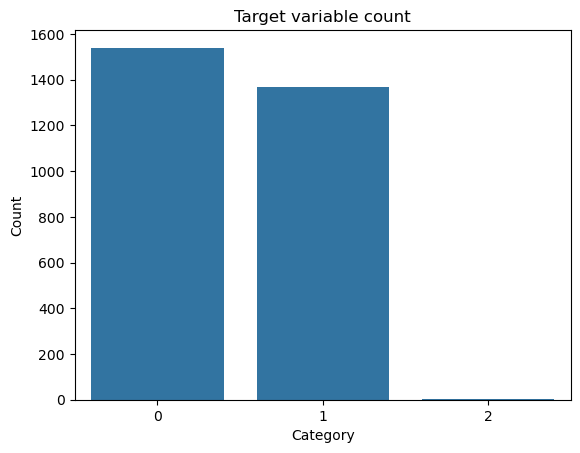

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

count = df['Category'].value_counts()
sns.barplot(x=count.index, y=count.values)

plt.title('Target variable count')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


From the plot above, you can see there is no class imbalance in the target variable. We have almost equal instances for negative class ("0" - Real) and the class of interest ("1" - Fake).

In [170]:
#distribution of fake and real news among subjects
#plt.figure(figsize=(12,8))
#sns.countplot(x = "subject", data=df, hue = "label")
#plt.show()

<a id = "4" ></a>
# Data Cleaning
We will begin with the preprocessing steps before the text is fed into the model for prediction. 

In [171]:
#data cleaning content	source	author	time

#combining the title and text columns
#df['text'] = df['title'] + " " + df['text']
#deleting few columns from the data 
#del df['source']
#del df['author']
#del df['time']

<a id = "5" ></a>
## Removing stopwords
One of the major forms of pre-processing is to filter out useless data. In NLP, useless words, are referred to as stop words. We will use the `nltk` library for this purpose. This is how we are making our processed content more efficient by removing words that do not contribute to any future operations.

In [172]:
def clean_text(text):
    if isinstance(text, str):  # Check if text is a string
        text = remove_brackets(text)
        text = remove_urls(text)
        text = remove_stopwords(text)
        return text
    return ""  # Return an empty string for NaN or non-string values

df['Message'] = df['Message'].astype(str)  # Ensure all values are strings
df['Message'] = df['Message'].apply(clean_text)

In [173]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords

# Choosing the language as English
stop = set(stopwords.words('english'))

# Removing punctuation marks
punctuation = list(string.punctuation)

# Adding punctuations to the list of stop words 
stop.update(punctuation)

# Removing square brackets
def remove_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

# Removing URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Removing stopwords
def remove_stopwords(text):
    final_text = []
    text = text.lower()
    for i in text.split():
        if i.strip() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# Cleaning text
def clean_text(text):
    if isinstance(text, str):  # Avoid errors with NaN values
        text = remove_brackets(text)
        text = remove_urls(text)
        text = remove_stopwords(text)
        return text
    return ""  # Return empty string if it's not a valid text

# Apply function on text column
df['Message'] = df['Message'].astype(str)  # Convert all values to strings
df['Message'] = df['Message'].apply(clean_text)

df['Message'].head()  # Check the first few cleaned messages


0    subject: naturally irresistible corporate iden...
1    subject: stock trading gunslinger fanny merril...
2    subject: unbelievable new homes made easy im w...
3    subject: 4 color printing special request addi...
4    subject: money get software cds software compa...
Name: Message, dtype: object

<a id = "6" ></a>
## Lemmatization
The next step is to perform Lemmatization. It is the process of converting a word to its base form. For example: 'Caring' -> 'Care'; 'hanging' -> 'hang'

In [174]:
#lemmatization
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

#A function which takes a sentence/corpus and gets its lemmatized version.
def lemmatize_text(text):
    token_words=word_tokenize(text) 
#we need to tokenize the sentence or else lemmatizing will return the entire sentence as is.
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

#Apply function on text column
df['Message']=df['Message'].apply(lemmatize_text)
df

,Id,Category,Message
0,1.0,1,subject : naturally irresistible corporate ide...
1,2.0,1,subject : stock trading gunslinger fanny merri...
2,3.0,1,subject : unbelievable new home made easy im w...
3,4.0,1,subject : 4 color printing special request add...
4,5.0,1,subject : money get software cd software compa...
...,...,...,...
2905,2909.0,0,subject : term paper please respond excel file...
2906,2910.0,0,subject : action anjam resignation sit anjam l...
2907,2911.0,0,subject : india database jim wade aware workin...
2908,2912.0,0,subject : invitation wharton et event agree go...


<a id = "7" ></a>
## Word Cloud
### Fake News Word Cloud


### Real News Word Cloud

#word cloud for real news
cloud = WordCloud(max_words = 500, stopwords = STOPWORDS, background_color = "white").generate(" ".join(df[df.Category == 0].Message))
plt.figure(figsize=(40, 30))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<a id = "8" ></a>
# N-gram Analysis

In [175]:
#finding n-grams
texts = ''.join(str(df['Message'].tolist()))

# first get individual words
tokenized = texts.split()

<a id = "9" ></a>
## Unigram Analysis

Text(0.5, 0, '# of Occurances')

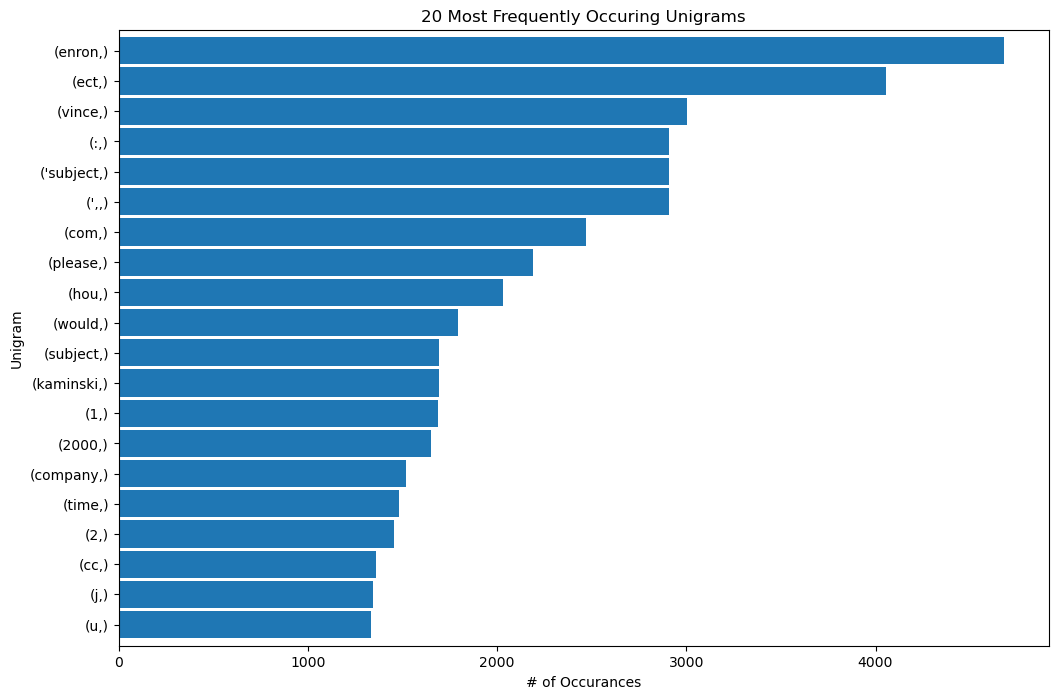

In [176]:
#unigram
unigram = (pd.Series(nltk.ngrams(tokenized, 1)).value_counts())[:20]
unigram.sort_values().plot.barh(width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Unigrams')
plt.ylabel('Unigram')
plt.xlabel('# of Occurances')

<a id = "10" ></a>
## Bigram Analysis

Text(0.5, 0, '# of Occurances')

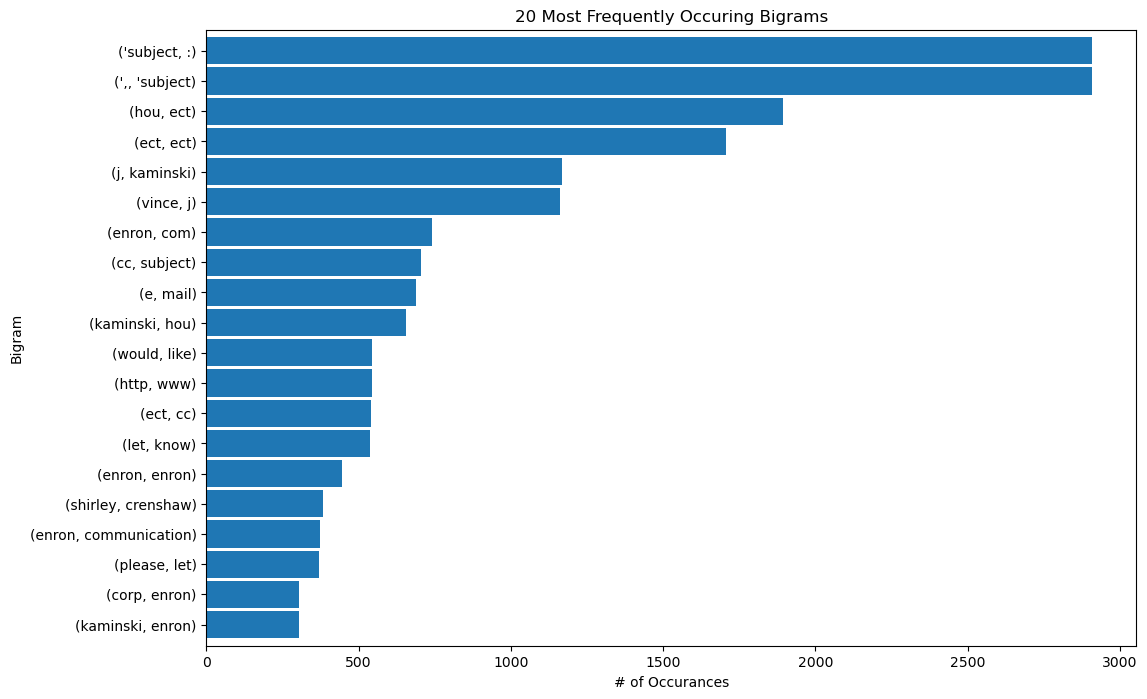

In [177]:
#bigrams
bigram = (pd.Series(nltk.ngrams(tokenized, 2)).value_counts())[:20]
bigram.sort_values().plot.barh(width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

<a id = "11" ></a>
## Trigram Analysis

Text(0.5, 0, '# of Occurances')

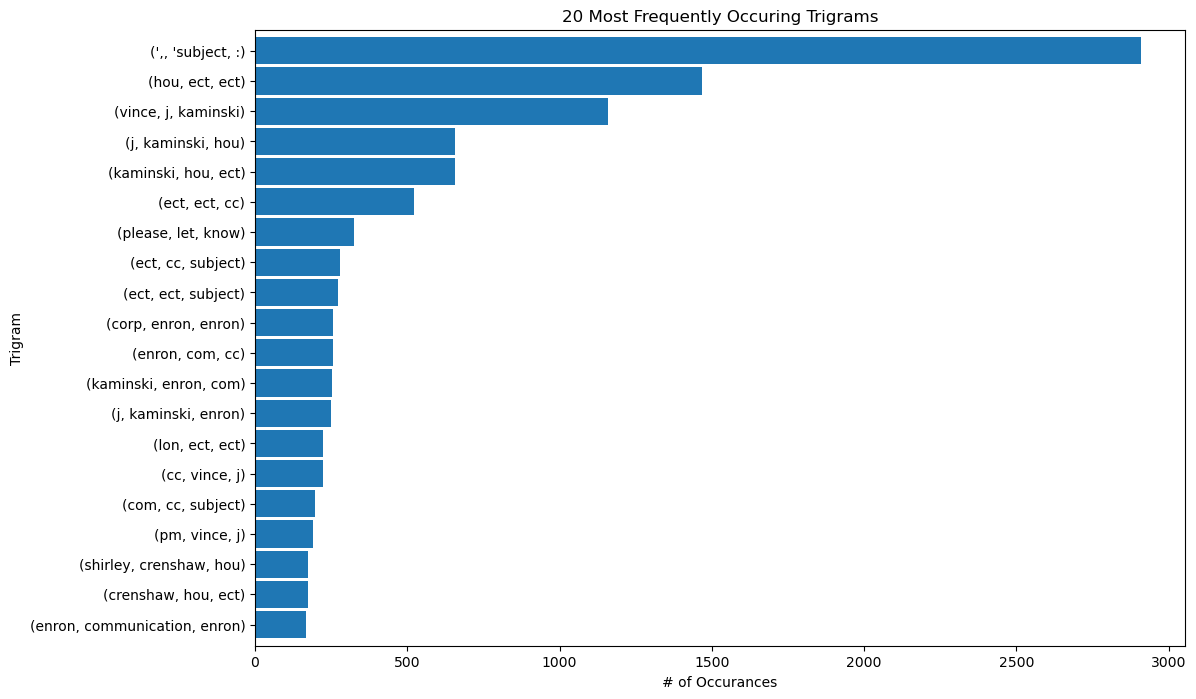

In [178]:
#trigrams
trigram = (pd.Series(nltk.ngrams(tokenized, 3)).value_counts())[:20]
trigram.sort_values().plot.barh(width=.9, figsize=(12, 8))
a=1.47
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

<a id = "12" ></a>
# Modeling
In this step, I am making use of various Classification models for prediction. The models use cleaned text data for analysis.

#### Using TF-IDF Vectorizer
This is an acronym than stands for "Term Frequency – Inverse Document Frequency" which are the components of the resulting scores assigned to each word.The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.

In [179]:
def get_prediction1(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100*a,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    print(vectorizer.get_feature_names())


from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size = 0.3, random_state= 0)

classifiers = [LogisticRegression(),KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(),MultinomialNB()]
for classifier in classifiers:
    print("\n\n", classifier)
    get_prediction1(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

In [180]:
#modeling
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
   
   


In [181]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
#import SwarmPackagePy

In [182]:
pip install git+https://github.com/manuel-calzolari/sklearn-genetic


Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/manuel-calzolari/sklearn-genetic to c:\users\aleen\appdata\local\temp\pip-req-build-ijcj8cj5
  Resolved https://github.com/manuel-calzolari/sklearn-genetic to commit a50ff08b0cc4d06c1ed3100025c721568f26d1cb
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/manuel-calzolari/sklearn-genetic 'C:\Users\aleen\AppData\Local\Temp\pip-req-build-ijcj8cj5'


In [183]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from genetic_selection import GeneticSelectionCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [184]:
def geneticAlgorithm():
    global classifier
    text.delete('1.0', END)
    global ga_acc
    train = pd.read_csv(filename)
    test = pd.read_csv('heart_dataset/test.txt')
    test_X = test.values[:, 0:13] 
    X = train.values[:, 0:13] 
    y = train.values[:, 13]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
    #estimator = svm.SVC(C=2.0,gamma='scale',kernel = 'rbf', random_state = 0)
    
    selector = GeneticSelectionCV(estimator,
                                  cv=5,
                                  verbose=1,
                                  scoring="accuracy",
                                  max_features=10,
                                  n_population=50,
                                  crossover_proba=0.5,
                                  mutation_proba=0.2,
                                  n_generations=200,
                                  crossover_independent_proba=0.5,
                                  mutation_independent_proba=0.05,
                                  tournament_size=3,
                                  n_gen_no_change=10,
                                  caching=True,
                                  n_jobs=-1)
    selector = selector.fit(X, y)
    y_pred = selector.predict(X_test)
    prediction_data = prediction(X_test, selector) 
    ga_acc = cal_accuracy(prediction_data, prediction_data,'GA Algorithm Accuracy, Classification Report & Confusion Matrix',2)
    classifier = selector
    cm = confusion_matrix(prediction_data, prediction_data)
    total=sum(sum(cm))
    selector = selector.fit(X_data,Y_data)

In [185]:
#selector = selector.fit(X_data,Y_data)
#y_pred = selector.predict(X_test)

In [186]:
#vectorizer=TfidfVectorizer() 
#print(vectorizer.get_feature_names())


X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size = 0.3, random_state= 0)

classifiers = [LogisticRegression(),KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(),MultinomialNB(),LinearSVC()]
for classifier in classifiers:
    print("\n\n", classifier)
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)
    
lr=[LogisticRegression()]


In [187]:
#pipeline implementation

X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size = 0.3, random_state= 0)

classifiers = [LogisticRegression(),KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(),MultinomialNB(),LinearSVC()]
for classifier in classifiers:
    print("\n\n", classifier)
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)
    
lr=[LogisticRegression()]





 LogisticRegression()
Accuarcy: 98.63
Confusion Matrix: 
 [[440   9   0]
 [  2 421   0]
 [  1   0   0]]


 KNeighborsClassifier()
Accuarcy: 96.91
Confusion Matrix: 
 [[442   7   0]
 [ 19 404   0]
 [  1   0   0]]


 DecisionTreeClassifier()
Accuarcy: 95.88
Confusion Matrix: 
 [[434  15   0]
 [ 20 403   0]
 [  1   0   0]]


 GradientBoostingClassifier()
Accuarcy: 96.79
Confusion Matrix: 
 [[426  23   0]
 [  4 419   0]
 [  1   0   0]]


 RandomForestClassifier()
Accuarcy: 97.82
Confusion Matrix: 
 [[439  10   0]
 [  8 415   0]
 [  1   0   0]]


 MultinomialNB()
Accuarcy: 96.79
Confusion Matrix: 
 [[445   4   0]
 [ 23 400   0]
 [  1   0   0]]


 LinearSVC()
Accuarcy: 98.85
Confusion Matrix: 
 [[442   7   0]
 [  2 421   0]
 [  1   0   0]]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [188]:
import numpy as np 
import pickle
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [189]:
train = pd.read_csv('Email spam.csv')

In [190]:
train

,Id,spam,text
0,1.0,1.0,Subject: naturally irresistible your corporate...
1,2.0,1.0,Subject: the stock trading gunslinger fanny i...
2,3.0,1.0,Subject: unbelievable new homes made easy im ...
3,4.0,1.0,Subject: 4 color printing special request add...
4,5.0,1.0,"Subject: do not have money , get software cds ..."
...,...,...,...
2905,2909.0,0.0,Subject: re : term papers please respond to ...
2906,2910.0,0.0,Subject: re : actions on anjam ' s resignation...
2907,2911.0,0.0,"Subject: india database jim / wade , as you ..."
2908,2912.0,0.0,Subject: re : invitation - wharton et events ...


In [191]:
#
train=train.dropna()

In [192]:
train

,Id,spam,text
0,1.0,1.0,Subject: naturally irresistible your corporate...
1,2.0,1.0,Subject: the stock trading gunslinger fanny i...
2,3.0,1.0,Subject: unbelievable new homes made easy im ...
3,4.0,1.0,Subject: 4 color printing special request add...
4,5.0,1.0,"Subject: do not have money , get software cds ..."
...,...,...,...
2905,2909.0,0.0,Subject: re : term papers please respond to ...
2906,2910.0,0.0,Subject: re : actions on anjam ' s resignation...
2907,2911.0,0.0,"Subject: india database jim / wade , as you ..."
2908,2912.0,0.0,Subject: re : invitation - wharton et events ...


In [193]:
train[train['spam']=='its termination would not  have such a phenomenal impact on the power situation .  however '].shape

(0, 3)

In [194]:
df_x=train['text']
df_y=train['spam']

In [195]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.3, random_state=9)
print(x_train.shape)
print(x_test.shape)

(2035,)
(873,)


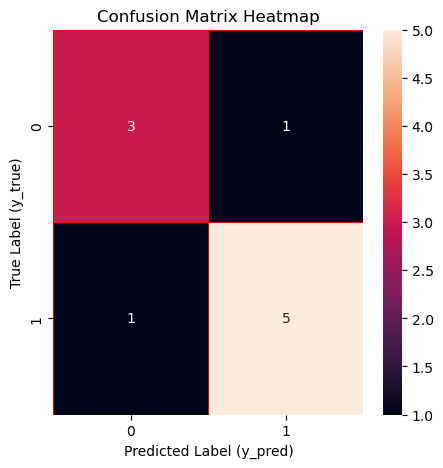

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Sample true labels and predicted labels
y_true = [1, 0, 1, 1, 0, 0, 1, 0, 1, 1]  # Actual labels
y_pred = [1, 0, 1, 0, 0, 1, 1, 0, 1, 1]  # Predicted labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the heatmap
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("Predicted Label (y_pred)")
plt.ylabel("True Label (y_true)")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [197]:
data=df.iloc[10:15,1]
data

10    1
11    1
12    1
13    1
14    1
Name: Category, dtype: int64

In [198]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Message'])

print("Number of Features (Columns):", X.shape[1])
print("Number of Samples (Rows):", X.shape[0])


Number of Features (Columns): 27085
Number of Samples (Rows): 2909
